
 R0= 0.025
 probability of takeoff= 0
 (maximum no. infecteds,timestamp)= (12, 34)
 Total infected= 88
 Length of epidemic= 122
     Time of event     S    E    I    A     R
0         0.000000  99.0  1.0  0.0  0.0   0.0
1         2.031550  98.0  1.0  0.0  1.0   0.0
2         3.711084  98.0  0.0  1.0  1.0   0.0
3         5.186605  98.0  0.0  0.0  1.0   1.0
4         5.282687  97.0  1.0  0.0  1.0   1.0
..             ...   ...  ...  ...  ...   ...
229     107.110558  13.0  0.0  1.0  0.0  86.0
230     111.785701  12.0  1.0  1.0  0.0  86.0
231     113.844786  12.0  0.0  2.0  0.0  86.0
232     114.051913  12.0  0.0  1.0  0.0  87.0
233     122.429520  12.0  0.0  0.0  0.0  88.0

[234 rows x 6 columns]
Figure(640x480)
Figure(640x480)


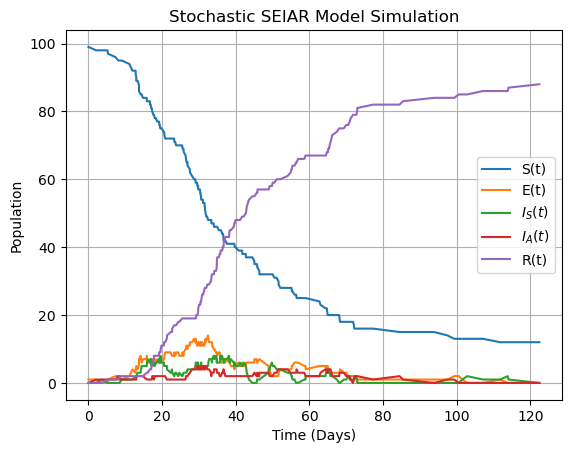

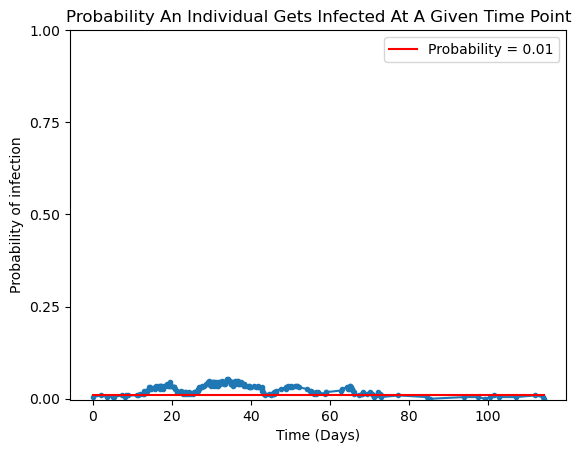

In [140]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sun Dec  3 21:05:15 2023

@author: jaden
"""
#%% Calculator

def Calculator(No_of_staff,
              Bubbles,
              Hybrid_work,
              Testing,
              Social_distancing,
              Ventilation,
              Masks,
              # Intervention Kwargs
              Bubble_interaction = 0.01, Bubble_1_pop = None, Bubble_2_pop = None,    # Bubble Kwarg (bubble interaction rate)
              Staff_in_office = None,                                                 # Hybrid Kwarg (number of staff left in the office)
              Testing_freq = 7,                                                       # Testing Kwarg (frequency in days of tests)
              Social_Dist_beta_reduction = 0.216,                                     # Distancing Kwarg (New R0 given social distancing)
              No_windows = 15, Q_filt = 361,                                          # Ventilation Kwarg (Windows and air purifier)
              Mask_type = 'surgical',                                                 # Mask Kwarg (Type of mask)
              # Rates
              beta2 = 0.5166,                                                            # rate of transmission from S to E due to contact with infectious (asy & sym)
              omega_sy = 0.196,                                                       # rate from E to I_A
              omega_asy = 0.196,                                                      # rate from E to I_S
              gamma = 0.18,                                                           # recovery rate of pathogen
              a1 = 0.1,                                                               # proportion of interation with an infectious environment
              delta = 0.649,                                                          # proportion of symptomatic infectious people
              # Wells riley values
              pwr = 0.48, q = 1217, V = 1000, Air_exchange = 4, working_hours = 8,      # Wells Riley paramters
              # Initial population
              E = 1, I = 0, A = 0, E2 = 1, I2 = 0, A2 = 0,
              # Simulations to complete
              Number_of_simulations = 100000
              ):
    
    gamma_sy = gamma*delta
    gamma_asy = gamma*(1-delta)
    
    # Q for wells riley
    Q = 4*V
    
    # If a specific number of staff in the office for hybrid work is not specified set it to 50%
    if Staff_in_office == None:
        Staff_in_office = 0.5 * No_of_staff
     
    # If masks are not being used set mask_type to 0 so wells riley calculates no masks
    if Masks == False:
        n1, n2 = 0, 0
        Mask_type = 0
    elif Mask_type == "surgical":
        n1,n2 = 0.5, 0.5
    elif Mask_type == "N95":
        n1, n2 = 0.9, 0.9
     
    # If ventilation  isn't in use then change Q-filt to 0 i.e. no air purifier in wells riley and Number of windowsto 0
    if Ventilation == False:
        Q_filt = 0
        No_windows = 0
        
    # Rename number of staff population
    population = No_of_staff
    
    # Import modules
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd
    
    # Make intervention adjustments
    
    # Hybrid
    if Hybrid_work == True:
        # Change number of susceptibles
        population = Staff_in_office
        
    # Bubbles
    if Bubbles == True:
        # Adjust population
        # Default
        if Bubble_1_pop == None and Bubble_2_pop == None:
            Bubble_1_pop = population//2
            Bubble_2_pop = population//2
    
    # Testing
    if Testing == True:
        include_testing = True
    else: 
        include_testing = False
    
    # Masks, ventilation and SD
    # Masks and ventilation
    if Masks == True or Ventilation == True:
        beta2 = (q*pwr*working_hours)*(1-n1)*(1-n2) / (V*(Air_exchange + No_windows*0.4)+Q_filt)
                
        # If SD true make change to beta2
        if Social_distancing == True:
            beta2 = Social_Dist_beta_reduction*beta2
    
    # Only SD so just change beta2 value
    elif Social_distancing == True:
        beta2 = Social_Dist_beta_reduction*beta2
    
    # Calculate reproduction number
    R0 = beta2/gamma
    
    # Calculate probability epidemic takes off in our office
    if 1 > 1/R0:
        prob_take_off = 1 - ((1/R0)**(E+I+A))
    else:
        prob_take_off = 0
    
    # Define an exponential random variable for later use
    def exponential(lam):
        return np.random.exponential(lam)
    
    # Define an uniform random variable for later use
    def uniform(a,b):
        return np.random.uniform(a,b)
    
    # Define wells riley model for day by day P(infection)
    def Wells_Riley(pwr,q,Q,t,V,I,W,Mask,filt):
        
        # Adjust for mask type
        if Mask == 0:
            n1 = 0
            n2 = 0  
        elif Mask == 'surgical':
            n1 = 0.5
            n2 = 0.5    
        elif Mask == 'N95':
            n1 = 0.9
            n2 = 0.9      
        
        # Adjust for number of windows
        if W != 0:
            Q_W = V*((W*0.4))
        else:
            Q_W = 0
        
        # Wells Riley equation
        Prob_inf = 1 - np.exp(-I*(q*pwr*t)*(1-n1)*(1-n2)/(Q + Q_W + filt))

        return Prob_inf

    # Set up initial population
    if Bubbles == True:
        s = [Bubble_1_pop - E - I - A]
        e = [E]
        i = [I]
        a = [A]
        r = [0]
        s2 = [Bubble_2_pop - E2 - I2 - A2]
        e2 = [E2]
        i2 = [I2]
        a2 = [A2]
        r2 = [0]
        
    else:
        s = [population - E - I - A]
        e = [E]
        i = [I]
        a = [A]
        r = [0]

    
    # Set up time
    time = [0]
    time2 = [0]
    
    # Early end point if pandemic is still going
    time_end = 10000
    
    # Initiate list for wells riley outputs
    Prob_inf_list = []
    Prob_inf_list2 = []
    
    # Testing counters
    counter = 1
    pos_tests = 0
    
    for run in range(Number_of_simulations):
        # Begin gillespie algorithm
        while time[-1] < time_end:
            
            # Remove people for weekly testing
            if include_testing == True:
                if time[-1] > (counter*Testing_freq):
                    # Testing day
                    s.append(s[-1])
                    r.append(r[-1] + int(e[-1]*0.38) + int(i[-1]*0.57) + int(a[-1]*0.4))
                    pos_tests += int(e[-1]*0.38) + int(i[-1]*0.57) + int(a[-1]*0.4)
                    
                    e.append(e[-1]-int(e[-1]*0.38))
                    i.append(i[-1]-int(i[-1]*0.57))
                    a.append(a[-1] - int(a[-1]*0.4))
                    
                    wr = Wells_Riley(pwr,q,Q,working_hours,V,i[-1]+a[-1],No_windows,Mask_type,Q_filt)
                    Prob_inf_list.append(wr)
    
                    time.append(time[-1])
                    
                    # Do it also for 2nd bubble if there is one
                    if Bubbles == True:
                        # Testing day
                        s2.append(s2[-1])
                        r2.append(r2[-1] + int(e2[-1]*0.38) + int(i2[-1]*0.57) + int(a2[-1]*0.4))
                        pos_tests += int(e2[-1]*0.38) + int(i2[-1]*0.57) + int(a2[-1]*0.4)
                        
                        e2.append(e[-1]-int(e2[-1]*0.38))
                        i2.append(i[-1]-int(i2[-1]*0.57))
                        a2.append(a[-1] - int(a2[-1]*0.4))
                        
                        wr2 = Wells_Riley(pwr,q,Q,working_hours,V,i2[-1]+a2[-1],No_windows,Mask_type,Q_filt)
                        Prob_inf_list2.append(wr2)
        
                        time2.append(time2[-1])
                        
                    counter += 1
    
                    continue
            
            if i[-1] == 0 and e[-1] == 0 and a[-1] == 0:
                break
            
            # Rates
            if Bubbles == True:
                exp_rate = beta2*s[-1]*(i[-1]+a[-1])/(1+a1*(i[-1]+a[-1])) + (Bubble_interaction*(i2[-1]+a2[-1]))
            else :
                exp_rate = beta2*s[-1]*(i[-1]+a[-1])/(1+a1*(i[-1]+a[-1]))
            asy_rate = (1-delta)*omega_asy*e[-1]
            inf_rate = delta*omega_sy*e[-1]
            rec_rate_asy = gamma_asy*(i[-1]+a[-1])
            rec_rate_sy = gamma_sy*(i[-1]+a[-1])
            
            if s[-1] == 0 :
                exp_rate = 0
                asy_rate = 0
            if e[-1] == 0:
                inf_rate = 0
            if i[-1] == 0:
                rec_rate_sy = 0
            if a[-1] == 0:
                rec_rate_asy = 0
            if time[-1] == 0:
                rec_rate_sy = 0
                rec_rate_asy = 0
            
            propensities = np.array([exp_rate,asy_rate,inf_rate,rec_rate_sy,rec_rate_asy])
            
            # Time
            time_inc = exponential(1/sum(propensities))
            time.append(time[-1]+time_inc)
            
            # Probabilities
            probs = propensities/propensities.sum()
    
            # Choose index of event
            def sample_discrete(probs):
                # Generate random number
                uniform_sample = uniform(0,1)
            
                # Find index
                i = 0
                p_sum = 0.0
                while p_sum < uniform_sample:
                    p_sum += probs[i]
                    i += 1
            
                return i - 1
            
            index = sample_discrete(probs)
            
            if index == 0:
                s.append(s[-1]-1)
                e.append(e[-1]+1)
                i.append(i[-1])
                a.append(a[-1])
                r.append(r[-1])
                
            elif index == 1:
                s.append(s[-1]-1)
                e.append(e[-1])
                i.append(i[-1])
                a.append(a[-1]+1)
                r.append(r[-1])
                
            elif index == 2:
                s.append(s[-1])
                e.append(e[-1]-1)
                i.append(i[-1]+1)
                a.append(a[-1])
                r.append(r[-1])
                
                
            elif index == 3:
                s.append(s[-1])
                e.append(e[-1])
                i.append(i[-1]-1)
                a.append(a[-1])
                r.append(r[-1]+1)
                
            elif index == 4:
                s.append(s[-1])
                e.append(e[-1])
                i.append(i[-1])
                a.append(a[-1]-1)
                r.append(r[-1]+1)
            
            wr = Wells_Riley(pwr,q,Q,working_hours,V,i[-1]+a[-1],No_windows,Mask_type,Q_filt)
            Prob_inf_list.append(wr)
            
            # If a second bubble is chosen then run a second stream
            if Bubbles == True:
                
                if i2[-1] == 0 and e2[-1] == 0 and a2[-1] == 0:
                    break
                
                # Rates
                exp_rate2 = beta2*s2[-1]*(i2[-1]+a2[-1])/(1+a1*(i2[-1]+a2[-1])) + (Bubble_interaction*(i[-1]+a[-1]))
                asy_rate2 = (1-delta)*omega_asy*e2[-1]
                inf_rate2 = delta*omega_sy*e2[-1]
                rec_rate_asy2 = gamma_asy*(i2[-1]+a2[-1])
                rec_rate_sy2 = gamma_sy*(i2[-1]+a2[-1])
                
                if s2[-1] == 0 :
                    exp_rate2 = 0
                    asy_rate2 = 0
                if e2[-1] == 0:
                    inf_rate2 = 0
                if i2[-1] == 0:
                    rec_rate_sy2 = 0
                if a2[-1] == 0:
                    rec_rate_asy2 = 0
                if time2[-1] == 0:
                    rec_rate_sy2 = 0
                    rec_rate_asy2 = 0
                
                propensities2 = np.array([exp_rate2,asy_rate2,inf_rate2,rec_rate_sy2,rec_rate_asy2])
                
                # Time
                time_inc = exponential(1/sum(propensities2))
                time2.append(time2[-1]+time_inc)
                
                # Probabilities
                probs2 = propensities2/propensities2.sum()
    
                # Choose index of event
                def sample_discrete(probs):
                    # Generate random number
                    uniform_sample = uniform(0,1)
                
                    # Find index
                    i = 0
                    p_sum = 0.0
                    while p_sum < uniform_sample:
                        p_sum += probs[i]
                        i += 1
                
                    return i - 1
                
                index = sample_discrete(probs2)
                
                if index == 0:
                    s2.append(s2[-1]-1)
                    e2.append(e2[-1]+1)
                    i2.append(i2[-1])
                    a2.append(a2[-1])
                    r2.append(r2[-1])
                    
                elif index == 1:
                    s2.append(s2[-1]-1)
                    e2.append(e2[-1])
                    i2.append(i2[-1])
                    a2.append(a2[-1]+1)
                    r2.append(r2[-1])
                    
                elif index == 2:
                    s2.append(s2[-1])
                    e2.append(e2[-1]-1)
                    i2.append(i2[-1]+1)
                    a2.append(a2[-1])
                    r2.append(r2[-1])
                    
                    
                elif index == 3:
                    s2.append(s2[-1])
                    e2.append(e2[-1])
                    i2.append(i2[-1]-1)
                    a2.append(a2[-1])
                    r2.append(r2[-1]+1)
                    
                elif index == 4:
                    s2.append(s2[-1])
                    e2.append(e2[-1])
                    i2.append(i2[-1])
                    a2.append(a2[-1]-1)
                    r2.append(r2[-1]+1)
                
                wr2 = Wells_Riley(pwr,q,Q,working_hours,V,i2[-1]+a2[-1],No_windows,Mask_type,Q_filt)
                Prob_inf_list2.append(wr2)
               
    
        if run == 0:
            s_avg = np.array(s)
            e_avg = np.array(e)
            i_avg = np.array(i)
            a_avg = np.array(a)
            r_avg = np.array(r)
            time_avg = np.array(time)
        else:
            s_avg += np.array(s)
            e_avg += np.array(e)
            i_avg += np.array(i)
            a_avg += np.array(a)
            r_avg += np.array(r)
            time_avg += np.array(time)
                
        if Bubbles == True:
            if run == 0:
                s2_avg = np.array(s2)
                e2_avg = np.array(e2)
                i2_avg = np.array(i2)
                a2_avg = np.array(a2)
                r2_avg = np.array(r2)
                time_avg2 = np.array(time2)
            else:
                s2_avg += np.array(s2)
                e2_avg += np.array(e2)
                i2_avg += np.array(i2)
                a2_avg += np.array(a2)
                r2_avg += np.array(r2)
                time_avg2 += np.array(time2)
    
    s = s_avg/Number_of_simulations
    e = e_avg/Number_of_simulations
    i = i_avg/Number_of_simulations
    a = a_avg/Number_of_simulations
    r = r_avg/Number_of_simulations
    time = time_avg/Number_of_simulations
    
    if Bubbles == True:
        s2 = s2_avg/Number_of_simulations
        e2 = e2_avg/Number_of_simulations
        i2 = i2_avg/Number_of_simulations
        a2 = a2_avg/Number_of_simulations
        r2 = r2_avg/Number_of_simulations
        time2 = time_avg2/Number_of_simulations
        
    if Bubbles == True:
        fig1 = plt.figure(figsize=(12,4)) 
        gs = fig1.add_gridspec(1,2,wspace=0.5)
        (ax1,ax2) = gs.subplots()
        plt.suptitle('Stochastic SEIAR Model Simulation')
        
        ax1.plot(time,s, label='S(t)')
        ax1.plot(time,e, label='E(t)')
        ax1.plot(time,i, label=r'$I_S(t)$')
        ax1.plot(time,a, label=r'$I_A(t)$')
        ax1.plot(time,r, label='R(t)')
        ax1.legend()
        ax1.grid()
        ax1.set(xlabel='Time (Days)',ylabel='population',title='Bubble 1')
        
        ax2.plot(time2,s2, label='S(t)')
        ax2.plot(time2,e2, label='E(t)')
        ax2.plot(time2,i2, label=r'$I_S(t)$')
        ax2.plot(time2,a2, label=r'$I_A(t)$')
        ax2.plot(time2,r2, label='R(t)')
        ax2.legend()
        ax2.grid()
        ax2.set(xlabel='Time (Days)',ylabel='population',title='Bubble 2')

        fig1.savefig('sto_Simulation_bubbles.png')
        
        fig2 = plt.figure()
        plt.plot(time[:-1],Prob_inf_list,label = 'Bubble 1')
        plt.plot(time2[:-1],Prob_inf_list2, label = 'Bubble2')
        plt.legend()
        plt.xlabel('Time (Days)')
        plt.ylabel('Probability of infection')
        plt.yticks(np.linspace(0,1,5))
        plt.title('Daily Probability of Infection')
        fig2.savefig('Wells_Riley.png')
        
        inf_plus_asy = np.array(i)+np.array(a)
        maximum_infecteds = max(inf_plus_asy)
        maximum_index = int(np.where(inf_plus_asy==maximum_infecteds)[0][0])
        time_of_maximum = time[maximum_index]
        maximum1 = (maximum_infecteds,int(time_of_maximum))
        
        inf_plus_asy2 = np.array(i2)+np.array(a2)
        maximum_infecteds2 = max(inf_plus_asy2)
        maximum_index2 = int(np.where(inf_plus_asy2==maximum_infecteds2)[0][0])
        time_of_maximum2 = time2[maximum_index2]
        maximum2 = (maximum_infecteds2,int(time_of_maximum2))
        
        total_infecteds = r[-1]
        length_of_epidemic = time[-1]
        
        total_infecteds2 = r2[-1]
        length_of_epidemic2 = time2[-1]
        
        df_list = list(zip(list(time),list(s),list(e),list(i),list(a),list(r)))
        df = pd.DataFrame(df_list, columns=['Time of event','S','E','I','A','R'])
        
        df_list2 = list(zip(list(time2),list(s2),list(e2),list(i2),list(a2),list(r2)))
        df2 = pd.DataFrame(df_list2, columns=['Time of event','S2','E2','I2','A2','R2'])
        
        return ("\n R0= "+str(round(R0,3))+"\n probability of takeoff= "+str(round(prob_take_off,3))+"\n (maximum no. infecteds (bubble 1),timestamp)= "+str((int(maximum1[0]),maximum1[1]))+"\n (maximum no. infecteds (bubble 2),timestamp)= "+str((int(maximum2[0]),maximum2[1]))+"\n Total infected in bubble 1= "+ str(int(total_infecteds))+ "\n Lengh of epidemic in bubble 1= "+str(int(length_of_epidemic))+"\n Total infected in bubble 2= "+str(int(total_infecteds2))+ "\n Lengh of epidemic in bubble 2= "+str(int(length_of_epidemic2))+"\n"+ str(df)+ "\n"+str(df2)+"\n"+ str(fig1)+"\n"+ str(fig2))
        
    else:
        fig1 = plt.figure()
        plt.plot(time,s, label='S(t)')
        plt.plot(time,e, label='E(t)')
        plt.plot(time,i, label=r'$I_S(t)$')
        plt.plot(time,a, label=r'$I_A(t)$')
        plt.plot(time,r, label='R(t)')
        plt.legend()
        plt.grid()
        plt.xlabel('Time (Days)')
        plt.ylabel('Population')
        plt.title('Stochastic SEIAR Model Simulation')
        fig1.savefig('sto_Simulation.png')
    
        fig2 = plt.figure()
        plt.plot(time[:-1],Prob_inf_list,marker='.')
        plt.plot(time[:-1],np.ones(len(time[:-1]))*0.01,color = 'red',label = f'Probability = 0.01')
        plt.xlabel('Time (Days)')
        plt.ylabel('Probability of infection')
        plt.yticks(np.linspace(0,1,5))
        plt.title('Probability An Individual Gets Infected At A Given Time Point')
        plt.legend()
        fig2.savefig('Wells_Riley.png')
        
        inf_plus_asy = np.array(i)+np.array(a)
        maximum_infecteds = max(inf_plus_asy)
        maximum_index = int(np.where(inf_plus_asy==maximum_infecteds)[0][0])
        time_of_maximum = time[maximum_index]
        maximum = (maximum_infecteds,int(time_of_maximum))
        
        total_infecteds = r[-1]
        length_of_epidemic = time[-1]
        
        df_list = list(zip(list(time),list(s),list(e),list(i),list(a),list(r)))
        df = pd.DataFrame(df_list, columns=['Time of event','S','E','I','A','R'])
        return ("\n R0= "+str(round(R0,3))+"\n probability of takeoff= "+str(round(prob_take_off,3))+"\n (maximum no. infecteds,timestamp)= "+str((int(maximum[0]),maximum[1]))+"\n Total infected= "+str(int(total_infecteds))+"\n Length of epidemic= "+str(int(length_of_epidemic))+"\n"+ str(df)+"\n"+ str(fig1)+"\n"+ str(fig2))

#%% Results
result = Calculator(100,False,False,False,False,True,True,Mask_type = 'N95')
#No_of_staff,Bubbles,Hybrid_work,Testing,Social_distancing,Ventilation,Masks)
print(result)


In [115]:
import numpy as np
np.ones(3)*0.01

array([0.01, 0.01, 0.01])